# Notebook for evaluation of the Mn model performance


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import stations
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import glob
from salishsea_tools import nc_tools
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/ocean/brogalla/GEOTRACES/analysis-birgit/cmocean-master/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.104, 'tol_lat': 0.0388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012},
        }
):

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # Added by BMM March 2017
        # If including points outside of domain:
        return np.nan, np.nan
        # raise ValueError(
        #    'No model point found. tol_lon/tol_lat too small or '
        #    'lon/lat outside of domain.')
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest

        # Avoiding array indexing because some functions
        # pass in model_lons and model_lats as netcdf4 objects
        # (which treat 'model_lons[j_list, i_list]' differently)
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


In [3]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [4]:
def fill_nans(input_var):
    vector = np.zeros(24)
    for i in range(0,24):
        if i < len(input_var):
            vector[i] = input_var[i]
        else:
            vector[i] = np.nan
    return vector

In [5]:
def search_depth(obs_depth, model_depths):
    k_list = np.array([])
    for i in range(0,len(obs_depth)):
        diff_list = np.array([])
        for n in range(0, len(model_depths)):
            diff = np.abs(obs_depth[i] - model_depths[n])
            diff_list = np.append(diff_list, diff)
        k = np.argmin(diff_list) # for list of indices associated with depths
        k_list = np.append(k_list, k)
    return k_list

## Load model bathymetry and results

Bathymetry:

In [6]:
land_color = "#8b7765"

# load bathymetry file:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc')
mesh_lon = mesh.variables['nav_lon']
mesh_lat = mesh.variables['nav_lat']
mesh_bathy = mesh.variables['hdept'][0]
mesh_lon = np.array(mesh_lon)
mesh_lat = np.array(mesh_lat)
mesh_bathy = np.array(mesh_bathy)

In [7]:
def find_index_ANHA12_full(transect_lons, transect_lats, ANHA12_lon=mesh_lon, ANHA12_lat=mesh_lat):
    # input:   ANHA12_lon, ANHA12_lat       --- 2400x1632 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    for k in range(0,len(transect_lons)):
        i, j = find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12_lon, ANHA12_lat)
        transect_i = np.append(transect_i, i)
        transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

Sample results:

In [8]:
Mn_model = nc.Dataset('../../analysis/Mn_monthlyave_2002.nc')
mn_dis = Mn_model.variables['dMn']
mn_dis = np.array(mn_dis)

In [9]:
c = nc.Dataset('/data/brogalla/runs_mn/mn001_2019-03-29T004931.179569-0400/' + \
               'ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20021227-20021231.nc','r')

# Load structure from sample dataset:
lat_model = c.variables['nav_lat']
lon_model = c.variables['nav_lon']
depths_model = c.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

In [10]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

## Load all observations

#### Campbell and Yeats, 1982: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.896.6307&rep=rep1&type=pdf

In [11]:
lat_1982 = [66.7567, 66.7483, 72.235, 74.333, 74.1783, 76.35167, 76.393, 78.32, 78.315, 66.7583]
lon_1982 = [-57.095, -60.25167, -65.9483, -94.263, -94.2433, -89.43, -89.305, -74.7167, \
           -74.2667, -57.0617]

# total manganese, not specifically dissolved:
tMn_1982_stn1  = [0.26, 0.10, 0.05, 0.06]
tMn_1982_stn2  = [0.10, 0.12, 0.20, 0.17, 0.22, 0.20]
tMn_1982_stn3  = [0.38, 0.33, 0.27, 0.34, 0.25, 0.23, 0.24, 0.27, 0.28, 0.21, 0.24, 0.16, \
                  0.21, 0.27, 0.17, 0.13, 0.15, 0.24, 0.11]
dMn_1982_stn3  = [0.20, 0.24, np.NaN, 0.29, 0.20, 0.17, 0.17, 0.19, 0.20, 0.16, 0.22, 0.08, \
                  0.14, 0.11, 0.10, 0.06, 0.13, 0.09, 0.09]
tMn_1982_stn4  = [0.30, 0.27, 0.23, 0.28, 0.38]
tMn_1982_stn5  = [0.31, 0.29, 0.33, 0.29, 0.33]
tMn_1982_stn6  = [0.56, 0.36, 0.22]
tMn_1982_stn7  = [0.40, 0.38, 0.32]
tMn_1982_stn8  = [0.19, 0.15, 0.17, 0.16, 0.14, 0.21, 0.16]
tMn_1982_stn9  = [0.32, 0.33, 0.19, 0.13, 0.12, 0.17, 0.18, 0.19]
tMn_1982_stn10 = [0.14, 0.15, 0.14, 0.13, 0.13, 0.10, 0.11, 0.12, 0.12, 0.13]

depths_1982_stn1  = [10, 75, 250, 400]
depths_1982_stn2  = [12, 20, 50, 110, 250, 505]
depths_1982_stn3  = [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 250, 500, 800, 1000, 1200, 1500, 1750, 2000, 2300]
depths_1982_stn4  = [10, 20, 50, 100, 150]
depths_1982_stn5  = [10, 20, 50, 100, 140]
depths_1982_stn6  = [10, 25, 75]
depths_1982_stn7  = [9, 20, 75]
depths_1982_stn8  = [15, 25, 50, 100, 200, 300, 400]
depths_1982_stn9  = [10, 20, 50, 100, 210, 305, 405, 500]
depths_1982_stn10 = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

#### Yeats and Westerlund, 1991: https://ac.els-cdn.com/0304420391900714/1-s2.0-0304420391900714-main.pdf?_tid=12ba389d-4f68-4967-bad0-2103cfe975e1&acdnat=1552929800_480578b2e506b2c3c50d3c44ef66221e

Samples collected in June, 1985 at a land-fast ice island.

In [12]:
lat_1991   = [81.723]
lon_1991   = [-93.4167]
depth_1991 = [60, 80, 80, 90, 100, 100, 110, 120, 150, 200, 270, 280]
dMn_1991   = [2.11, 1.35, 1.33, 1.22, 1.18, 1.89, 1.36, 1.27, 0.55, 0.62, 1.58, 0.51] #unfiltered

#### Yeats, 1988: https://archimer.ifremer.fr/doc/00106/21767/19341.pdf

stations drifted for ~80 km between first and last measurement. Samples collected in 1981 and 1983, not sure which month. Stn 1 is out of domain, so only look at station 2.

In [13]:
lat_1988        = [86]   #[82, 86]
lon_1988        = [-111] #[6, -111]
#dMn_1988_stn1   = [6.5, 3.9, 4.9, 4.1, 3.6, 5.2, 4.0, 4.9, 3.0, 2.9, 2.5, 3.3, 1.8, 3.4, 3.0, 6.3, 5.2, 2.8]
dMn_1988_stn2   = [2.2, 1.6, 2.2, 1.1, 0.7, 1.3, 0.5, 0.5, 0.2, 0.6, 0.2, 0.4, 0.45, 0.5, 0.8, 0.4, 0.3, 0.3]
#depth_1988_stn1 = [5, 10, 20, 35, 50, 75, 85, 90, 100, 175, 225, 300, 500, 775, 1000, 1800, 2000, 2500]
depth_1988_stn2 = [5, 10, 50, 80, 100, 150, 220, 250, 280, 350, 380, 410, 600, 800, 1000, 1250, 1350, 1375]

#### Cid et al., 2012: https://link.springer.com/content/pdf/10.1007%2Fs10872-012-0150-8.pdf

Stations don't really fall within my sub-domain, so probably won't use.

#### USGS Arctic Ocean Carbon Cruise 2012: https://pubs.usgs.gov/ds/0862/html/ds862_maps.html
in folder: /Research/Data/BCs. I'm unclear about at what depths these measurements were taken.

In [14]:
data = pd.read_csv("/ocean/brogalla/GEOTRACES/data/HLY1202_Metals_Profile.csv") 

In [15]:
lat_2012 = np.array(data.get('Latitude_(Decimal_Degrees)'))
lon_2012 = np.array(data.get('Longitude_(Decimal_Degrees)'))
dMn_2012 = np.array(data.get('Mn_ug/L'))

## Station locations:

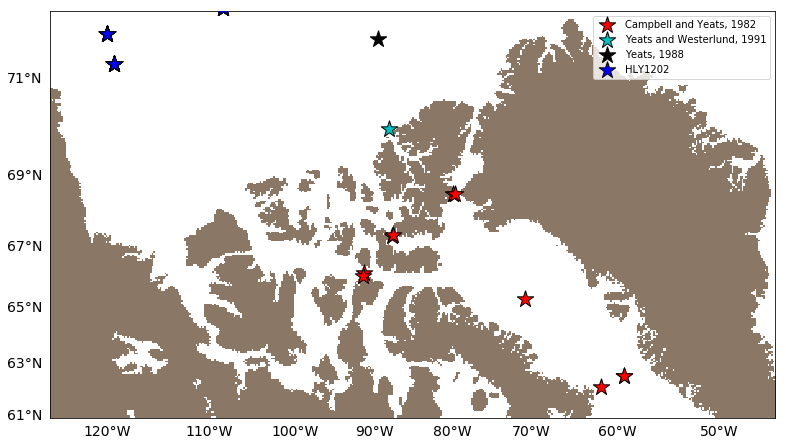

In [16]:
fig,ax = plt.subplots(figsize=(13,8))

proj=Basemap(projection='stere',lat_0 = 77.5, lon_0 = -85, resolution='i', width=4.1e6, height=2.3e6)
proj.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)
proj.drawlsmask(land_color = "#8b7765", ocean_color="none", resolution = 'l')

x_1982, y_1982 = proj(lon_1982, lat_1982)
x_1991, y_1991 = proj(lon_1991, lat_1991)
x_1988, y_1988 = proj(lon_1988, lat_1988)
x_2012, y_2012 = proj(lon_2012, lat_2012)
proj.scatter(x_1982, y_1982, color='r', marker='*',s=300,zorder=3, edgecolor='k', label='Campbell and Yeats, 1982')  
proj.scatter(x_1991, y_1991, color='c', marker='*',s=300,zorder=3, edgecolor='k', label='Yeats and Westerlund, 1991')  
proj.scatter(x_1988, y_1988, color='k', marker='*',s=300,zorder=3, edgecolor='k', label='Yeats, 1988')  
proj.scatter(x_2012, y_2012, color='b', marker='*',s=300,zorder=3, edgecolor='k', label='HLY1202')  
ax.legend(loc=1)

#### GEOTRACES:

In [17]:
Mn_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

In [18]:
dMn_BB1 = Mn_data['BB1'].dropna()[1:].astype('float')
dMn_BB2 = Mn_data['BB2'].dropna()[1:].astype('float')
dMn_BB3 = Mn_data['BB3'].dropna()[1:].astype('float')
dMn_CB1 = Mn_data['CB1'].dropna()[1:].astype('float')
dMn_CB2 = Mn_data['CB2'].dropna()[1:].astype('float')
dMn_CB3 = Mn_data['CB3'].dropna()[1:].astype('float')
dMn_CB4 = Mn_data['CB4'].dropna()[1:].astype('float')
dMn_CAA1 = Mn_data['CAA1'].dropna()[1:].astype('float')
dMn_CAA2 = Mn_data['CAA2'].dropna()[1:].astype('float')
dMn_CAA3 = Mn_data['CAA3'].dropna()[1:].astype('float')
dMn_CAA4 = Mn_data['CAA4'].dropna()[1:].astype('float')
dMn_CAA5 = Mn_data['CAA5'].dropna()[1:].astype('float')
dMn_CAA6 = Mn_data['CAA6'].dropna()[1:].astype('float')
dMn_CAA7 = Mn_data['CAA7'].dropna()[1:].astype('float')
dMn_CAA8 = Mn_data['CAA8'].dropna()[1:].astype('float')
dMn_CAA9 = Mn_data['CAA9'].dropna()[1:].astype('float')

In [19]:
depth_BB1 = Mn_data['Depth.2'].dropna()
depth_BB2 = Mn_data['Depth.3'].dropna()
depth_BB3 = Mn_data['Depth.4'].dropna()
depth_CB1 = Mn_data['Depth.14'].dropna()
depth_CB2 = Mn_data['Depth.15'].dropna()
depth_CB3 = Mn_data['Depth.16'].dropna()
depth_CB4 = Mn_data['Depth.17'].dropna()
depth_CAA1 = Mn_data['Depth.5'].dropna()
depth_CAA2 = Mn_data['Depth.6'].dropna()
depth_CAA3 = Mn_data['Depth.7'].dropna()
depth_CAA4 = Mn_data['Depth.8'].dropna()
depth_CAA5 = Mn_data['Depth.9'].dropna()
depth_CAA6 = Mn_data['Depth.10'].dropna()
depth_CAA7 = Mn_data['Depth.11'].dropna()
depth_CAA8 = Mn_data['Depth.12'].dropna()
depth_CAA9 = Mn_data['Depth.13'].dropna()

In [20]:
CAA1 = stations.CAA1()
CAA2 = stations.CAA2()
CAA3 = stations.CAA3()
CAA4 = stations.CAA4()
CAA5 = stations.CAA5()
CAA6 = stations.CAA6()
CAA7 = stations.CAA7()
CAA8 = stations.CAA8()
CAA9 = stations.CAA9()
CB1 = stations.CB1()
CB2 = stations.CB2()
CB3 = stations.CB3()
CB4 = stations.CB4()
BB1 = stations.BB1()
BB2 = stations.BB2()
BB3 = stations.BB3()
K1 = stations.K1()

names = ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
         'CB1', 'CB2', 'CB3', 'CB4', 'BB1', 'BB2', 'BB3', 'K1']
lons = [CAA1.lon, CAA2.lon, CAA3.lon, CAA4.lon, CAA5.lon, CAA6.lon, CAA7.lon, CAA8.lon, CAA9.lon, \
        CB1.lon, CB2.lon, CB3.lon, CB4.lon, BB1.lon, BB2.lon, BB3.lon, K1.lon]
lats = [CAA1.lat, CAA2.lat, CAA3.lat, CAA4.lat, CAA5.lat, CAA6.lat, CAA7.lat, CAA8.lat, CAA9.lat, \
        CB1.lat, CB2.lat, CB3.lat, CB4.lat, BB1.lat, BB2.lat, BB3.lat, K1.lat]

### Create a transect following the GEOTRACES stations:

In [21]:
# Connect these points with straight line segments:
transect_lons = [CB3.lon, CB2.lon, CB1.lon, CAA8.lon,\
                 CAA6.lon, CAA7.lon, CAA4.lon, \
                 CAA5.lon, CAA1.lon, CAA2.lon, CAA3.lon]
transect_lats = [CB3.lat, CB2.lat, CB1.lat, CAA8.lat,\
                 CAA6.lat, CAA7.lat, CAA4.lat, \
                 CAA5.lat, CAA1.lat, CAA2.lat, CAA3.lat]
transect_names = ['CB3', 'CB2', 'CB1', 'CAA8', \
                 'CAA6', 'CAA7', 'CAA4', \
                 'CAA5', 'CAA1', 'CAA2', 'CAA3']

In [22]:
transect_distances_m = np.array([])
for k in range(0,len(transect_lons)):
    if k == 0:
        distance_m = 0 #station distances
    else:
        distance_m = haversine(transect_lons[0], transect_lats[0], transect_lons[k], transect_lats[k])
    
    transect_distances_m = np.append(transect_distances_m, distance_m)

In [23]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

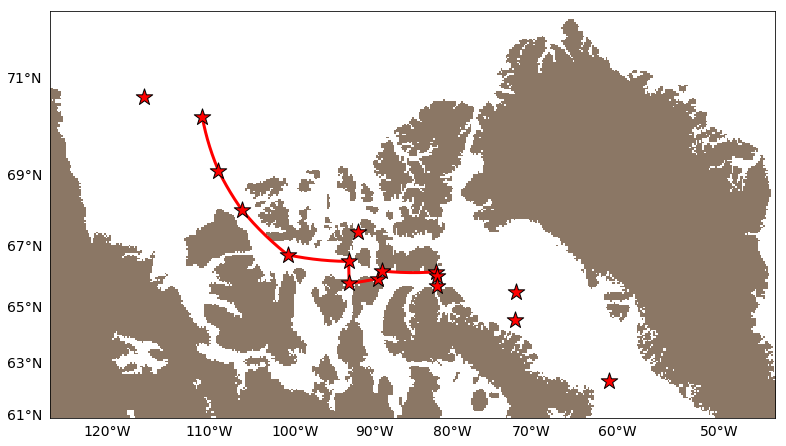

In [24]:
fig,ax = plt.subplots(figsize=(13,8))

proj=Basemap(projection='stere',lat_0 = 77.5, lon_0 = -85, resolution='i', width=4.1e6, height=2.3e6)
proj.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)
proj.drawlsmask(land_color = "#8b7765", ocean_color="none", resolution = 'l')

x_GEOTRACES, y_GEOTRACES = proj(lons, lats)
proj.scatter(x_GEOTRACES, y_GEOTRACES, color='r', marker='*',s=300,zorder=3, edgecolor='k')  

xt, yt = proj(transect_vlons, transect_vlats)
proj.plot(xt, yt, c='r', linewidth=3, zorder=2)  

Plot the measured values of dissolved Mn with depth:

In [25]:
depth_CB3 = np.array(depth_CB3)
depth_CB2 = np.array(depth_CB2)
depth_CB1 = np.array(depth_CB1)
depth_CAA9 = np.array(depth_CAA9)
depth_CAA8 = np.array(depth_CAA8)
depth_CAA7 = np.array(depth_CAA7)
depth_CAA6 = np.array(depth_CAA6)
depth_CAA5 = np.array(depth_CAA5)
depth_CAA4 = np.array(depth_CAA4)
depth_CAA3 = np.array(depth_CAA3)
depth_CAA2 = np.array(depth_CAA2)
depth_CAA1 = np.array(depth_CAA1)

In [26]:
dMn_CB3 = np.array(dMn_CB3)
dMn_CB2 = np.array(dMn_CB2)
dMn_CB1 = np.array(dMn_CB1)
dMn_CAA9 = np.array(dMn_CAA9)
dMn_CAA8 = np.array(dMn_CAA8)
dMn_CAA7 = np.array(dMn_CAA7)
dMn_CAA6 = np.array(dMn_CAA6)
dMn_CAA5 = np.array(dMn_CAA5)
dMn_CAA4 = np.array(dMn_CAA4)
dMn_CAA3 = np.array(dMn_CAA3)
dMn_CAA2 = np.array(dMn_CAA2)
dMn_CAA1 = np.array(dMn_CAA1)

In [27]:
transect_depths = np.column_stack((fill_nans(depth_CB3), fill_nans(depth_CB2), \
                                   fill_nans(depth_CB1), fill_nans(depth_CAA8), \
                                   fill_nans(depth_CAA6), fill_nans(depth_CAA7), fill_nans(depth_CAA4), \
                                   fill_nans(depth_CAA5), fill_nans(depth_CAA1), fill_nans(depth_CAA2), \
                                   fill_nans(depth_CAA3)))
transect_dMn = np.column_stack((fill_nans(dMn_CB3), fill_nans(dMn_CB2), \
                                   fill_nans(dMn_CB1), fill_nans(dMn_CAA8), \
                                   fill_nans(dMn_CAA6), fill_nans(dMn_CAA7), fill_nans(dMn_CAA4), \
                                   fill_nans(dMn_CAA5), fill_nans(dMn_CAA1), fill_nans(dMn_CAA2), \
                                   fill_nans(dMn_CAA3)))

Plot bathymetry for this area

In [28]:
transect_i, transect_j = find_index_ANHA12_full(transect_vlons, transect_vlats)

In [29]:
transect_bathy       = np.array([])
transect_lons_bathy  = np.array([])
transect_lats_bathy  = np.array([])
transect_distances   = np.array([])

for n in range(0,len(transect_i)):
    if n == 0:
        distance   = 0
    else:
        distance   = haversine(mesh_lon[transect_i[0], transect_j[0]],mesh_lat[transect_i[0], transect_j[0]], \
                               mesh_lon[transect_i[n], transect_j[n]],mesh_lat[transect_i[n], transect_j[n]])
        
    transect_bathy       = np.append(transect_bathy, mesh_bathy[transect_i[n], transect_j[n]])
    transect_lons_bathy  = np.append(transect_lons_bathy, mesh_lon[transect_i[n], transect_j[n]])
    transect_lats_bathy  = np.append(transect_lats_bathy, mesh_lat[transect_i[n], transect_j[n]])
    transect_distances   = np.append(transect_distances, distance)

In [30]:
transect_modeli, transect_modelj = find_index_ANHA12_sub(transect_vlons, transect_vlats)

In [31]:
lons_modelt = np.array([])
lats_modelt = np.array([])
transect_model_distances = np.array([])
mn_dis_t = np.zeros((len(depths_model), len(transect_modeli)))
for n in range(0,len(transect_modeli)):
    lon = lon_model[transect_modeli[n],transect_modelj[n]]
    lat = lat_model[transect_modeli[n],transect_modelj[n]]
    if n == 0:
        distance = 0
    else:
        distance = haversine(lon_model[transect_modeli[0], transect_modelj[0]],\
                             lat_model[transect_modeli[0], transect_modelj[0]], \
                             lon_model[transect_modeli[n], transect_modelj[n]],\
                             lat_model[transect_modeli[n], transect_modelj[n]])
    lons_modelt = np.append(lons_modelt, lon)
    lats_modelt = np.append(lats_modelt, lat)
    transect_model_distances = np.append(transect_model_distances, distance)
    
    mn_dt = mn_dis[10,:,transect_modeli[n], transect_modelj[n]]
    mn_dis_t[:,n] = mn_dt

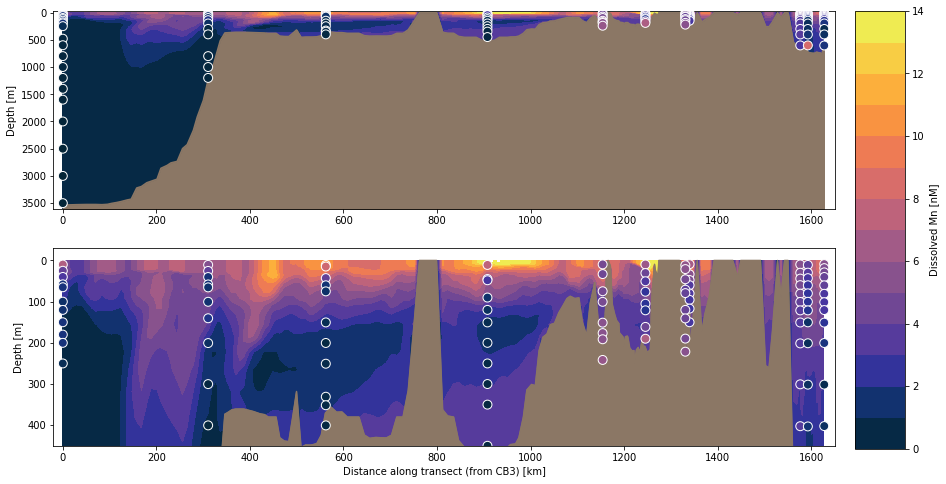

In [32]:
fig, ax = plt.subplots(2,1, figsize=(14,8))

# limits for colorbar:
vminmn = 0 
vmaxmn = 14

# plot stations:
for i in range(0,len(transect_lons)):
    sc = ax[0].scatter(transect_distances_m[i]*np.ones(24), transect_depths[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn[:,i], cmap=cmocean.cm.thermal,\
                       zorder = 3, s=80, edgecolors='w')
ax[0].set_ylabel('Depth [m]')
ax[0].invert_yaxis()
contour = ax[0].contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.thermal)
ax[0].plot(transect_distances, transect_bathy, c=land_color)
ax[0].fill_between(transect_distances, 4000, transect_bathy, color=land_color, zorder=1)
ax[0].set_ylim([3600, -30])
ax[0].set_xlim([-20, 1650])

# zoom in:
for i in range(0,len(transect_lons)):
    sc = ax[1].scatter(transect_distances_m[i]*np.ones(24), transect_depths[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn[:,i], cmap=cmocean.cm.thermal,\
                       zorder = 3, s=80, edgecolors='w')
ax[1].set_xlabel('Distance along transect (from CB3) [km]')
ax[1].set_ylabel('Depth [m]')
ax[1].invert_yaxis()
ax[1].set_ylim([450, -30])
ax[1].set_xlim([-20, 1650])
ax[1].plot(transect_distances, transect_bathy, c=land_color)
ax[1].contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.thermal)
ax[1].fill_between(transect_distances, 3500, transect_bathy, color=land_color, zorder=1)

cbar_ax = fig.add_axes([0.92, 0.12, 0.05, 0.76])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]') 

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Mn_transect_evaluation.png', bbox_inches='tight')

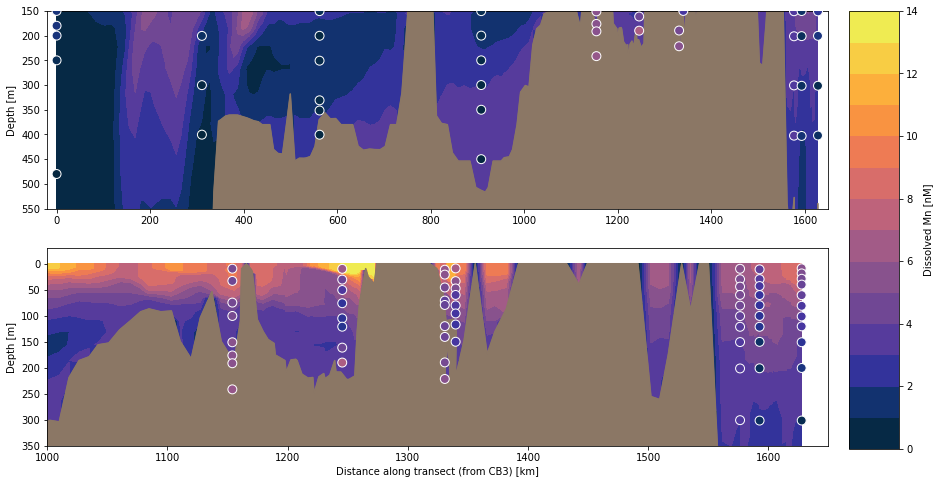

In [33]:
fig, ax = plt.subplots(2,1, figsize=(14,8))

# limits for colorbar:
vminmn = 0 
vmaxmn = 14

# plot stations:
for i in range(0,len(transect_lons)):
    sc = ax[0].scatter(transect_distances_m[i]*np.ones(24), transect_depths[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn[:,i], cmap=cmocean.cm.thermal,\
                       zorder = 3, s=80, edgecolors='w')
ax[0].set_ylabel('Depth [m]')
ax[0].invert_yaxis()
contour = ax[0].contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.thermal)
ax[0].plot(transect_distances, transect_bathy, c=land_color)
ax[0].fill_between(transect_distances, 4000, transect_bathy, color=land_color, zorder=1)
ax[0].set_ylim([550, 150])
ax[0].set_xlim([-20, 1650])

# zoom in:
for i in range(0,len(transect_lons)):
    sc = ax[1].scatter(transect_distances_m[i]*np.ones(24), transect_depths[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn[:,i], cmap=cmocean.cm.thermal,\
                       zorder = 3, s=80, edgecolors='w')
ax[1].set_xlabel('Distance along transect (from CB3) [km]')
ax[1].set_ylabel('Depth [m]')
ax[1].invert_yaxis()
ax[1].set_ylim([350, -30])
ax[1].set_xlim([1000, 1650])
ax[1].plot(transect_distances, transect_bathy, c=land_color)
ax[1].contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.thermal)
ax[1].fill_between(transect_distances, 3500, transect_bathy, color=land_color, zorder=1)

cbar_ax = fig.add_axes([0.92, 0.12, 0.05, 0.76])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]') 

## Compare Campbell & Yeats, 1982 with GEOTRACES stations

Units Campbell & Yeats: micro gram/L

\begin{equation}
 \frac{g}{L} = 54.9380450 \frac{g}{mol} \frac{mol}{L} = M
\end{equation}

In [34]:
colors_g = ['#00b3b3', '#82e1b3', '#eccaab']
colors_1982 = ['#4076a9', '#003865']

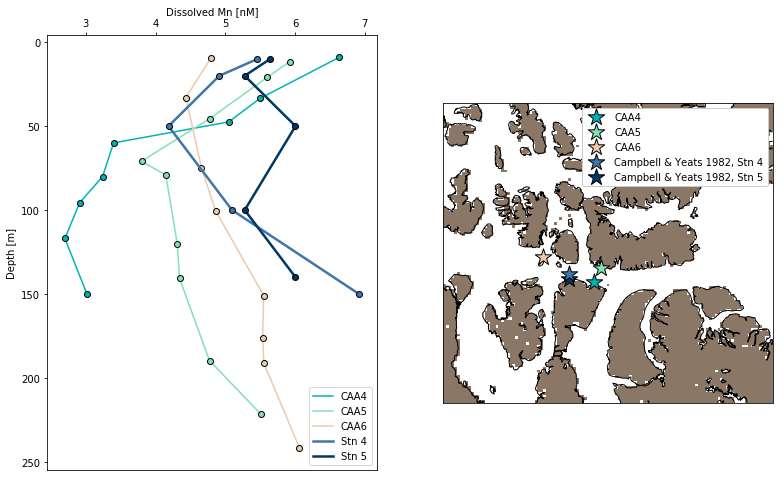

In [35]:
fig, ax = plt.subplots(1,2,figsize=(13,8))

ax[0].invert_yaxis()

j=0
for i in [6, 7, 4]:
    dMn   = transect_dMn[:,i]
    depth = transect_depths[:,i]
    ax[0].plot(dMn, depth, c=colors_g[j], zorder=1, label=transect_names[i])
    ax[0].scatter(dMn, depth, c=colors_g[j], zorder=2, edgecolor='k')
    j+=1

umn = 54.9380450 #molar weight Mn
ax[0].plot([i*10**3/umn for i in tMn_1982_stn4], depths_1982_stn4, zorder=3, \
           label='Stn 4', c=colors_1982[0], linewidth=2.5)
ax[0].scatter([i*10**3/umn for i in tMn_1982_stn4], depths_1982_stn4, zorder=4, \
              c=colors_1982[0], edgecolor='k')
ax[0].plot([i*10**3/umn for i in tMn_1982_stn5], depths_1982_stn5, zorder=3, \
           label='Stn 5', c=colors_1982[1], linewidth=2.5)    
ax[0].scatter([i*10**3/umn for i in tMn_1982_stn5], depths_1982_stn5, zorder=4, \
              c=colors_1982[1], edgecolor='k')    

ax[0].set_xlabel('Dissolved Mn [nM]')
ax[0].set_ylabel('Depth [m]')
ax[0].xaxis.tick_top()    
ax[0].xaxis.set_label_position('top') 
ax[0].legend(loc=4)

# map:
proj=Basemap(projection='stere',lat_0 = 75, lon_0 = -90, resolution='i', width=1.1e6, height=1e6, ax=ax[1])
proj.drawlsmask(land_color = "#8b7765", ocean_color="none", resolution = 'h')
proj.drawcoastlines()

x_GEOTRACES, y_GEOTRACES = proj(transect_lons, transect_lats)
proj.scatter(x_GEOTRACES[6], y_GEOTRACES[6], color=colors_g[0], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA4')  
proj.scatter(x_GEOTRACES[7], y_GEOTRACES[7], color=colors_g[1], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA5')  
proj.scatter(x_GEOTRACES[4], y_GEOTRACES[4], color=colors_g[2], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA6')  

x_1982, y_1982 = proj(lon_1982, lat_1982)
proj.scatter(x_1982[3], y_1982[3], color=colors_1982[0], marker='*',s=300,zorder=3, edgecolor='k', \
             label='Campbell & Yeats 1982, Stn 4')  
proj.scatter(x_1982[4], y_1982[4], color=colors_1982[1], marker='*',s=300,zorder=2, edgecolor='k', \
             label='Campbell & Yeats 1982, Stn 5')  
ax[1].legend(framealpha=1)

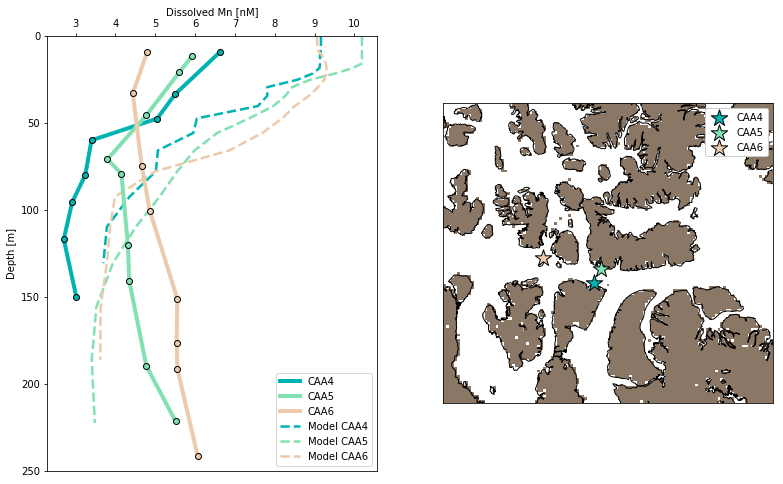

In [36]:
fig, ax = plt.subplots(1,2,figsize=(13,8))

ax[0].invert_yaxis()

j=0
for i in [6, 7, 4]:#range(4, 8):
    dMn   = transect_dMn[:,i]
    depth = transect_depths[:,i]
    #if i != 5:
    ax[0].plot(dMn, depth, c=colors_g[j], zorder=2, label=transect_names[i], linewidth=4)
    ax[0].scatter(dMn, depth, c=colors_g[j], zorder=3, edgecolor='k')
    j+=1  

# add in model profiles at these points:
model_CAA4i, model_CAA4j = find_index_ANHA12_sub(transect_lons[6], transect_lats[6])
model_CAA5i, model_CAA5j = find_index_ANHA12_sub(transect_lons[7], transect_lats[7])
model_CAA6i, model_CAA6j = find_index_ANHA12_sub(transect_lons[4], transect_lats[4])
mn_mCAA4 = mn_dis[10,:,model_CAA4i,model_CAA4j]*10**9
mn_mCAA4[mn_mCAA4 == 0] = np.nan
mn_mCAA5 = mn_dis[10,:,model_CAA5i,model_CAA5j]*10**9
mn_mCAA5[mn_mCAA5 == 0] = np.nan
mn_mCAA6 = mn_dis[10,:,model_CAA6i,model_CAA6j]*10**9
mn_mCAA6[mn_mCAA6 == 0] = np.nan
ax[0].plot(mn_mCAA4, depths_model, zorder=1, linestyle='--', label='Model CAA4', c=colors_g[0], linewidth=2.5)    
ax[0].plot(mn_mCAA5, depths_model, zorder=1, linestyle='--', label='Model CAA5', c=colors_g[1], linewidth=2.5)      
ax[0].plot(mn_mCAA6, depths_model, zorder=1, linestyle='--', label='Model CAA6', c=colors_g[2], linewidth=2.5)      
    
ax[0].set_xlabel('Dissolved Mn [nM]')
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim([250, 0])
ax[0].xaxis.tick_top()    
ax[0].xaxis.set_label_position('top') 
ax[0].legend(loc=4)

# map:
proj=Basemap(projection='stere',lat_0 = 75, lon_0 = -90, resolution='i', width=1.1e6, height=1e6, ax=ax[1])
proj.drawlsmask(land_color = "#8b7765", ocean_color="none", resolution = 'h')
proj.drawcoastlines()

x_GEOTRACES, y_GEOTRACES = proj(transect_lons, transect_lats)
proj.scatter(x_GEOTRACES[6], y_GEOTRACES[6], color=colors_g[0], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA4')  
proj.scatter(x_GEOTRACES[7], y_GEOTRACES[7], color=colors_g[1], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA5')  
proj.scatter(x_GEOTRACES[4], y_GEOTRACES[4], color=colors_g[2], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA6')  
ax[1].legend(framealpha=1)

# Model vs. Observation scatter plots

In [37]:
station_lons = lons[0:12]
station_lats = lats[0:12]
station_name  = names[0:12]

In [38]:
# find coordinates near the lat/lon of the stations:
station_i = np.array([])
station_j = np.array([])
for k in range(0,len(station_lons)):
    i, j = find_closest_model_point(station_lons[k], station_lats[k], lon_model, lat_model)
    station_i = np.append(station_i, i)
    station_j = np.append(station_j, j)

In [39]:
station_depths = np.column_stack((fill_nans(depth_CAA1), fill_nans(depth_CAA2),\
                                  fill_nans(depth_CAA3), fill_nans(depth_CAA4),\
                                  fill_nans(depth_CAA5), fill_nans(depth_CAA6),\
                                  fill_nans(depth_CAA7), fill_nans(depth_CAA8),\
                                  fill_nans(depth_CAA9), fill_nans(depth_CB1),\
                                  fill_nans(depth_CB2), fill_nans(depth_CB3)))
station_dMn = np.column_stack((fill_nans(dMn_CAA1), fill_nans(dMn_CAA2), \
                                   fill_nans(dMn_CAA3), fill_nans(dMn_CAA4), \
                                   fill_nans(dMn_CAA5), fill_nans(dMn_CAA6), fill_nans(dMn_CAA7), \
                                   fill_nans(dMn_CAA8), fill_nans(dMn_CAA9), fill_nans(dMn_CB1), \
                                   fill_nans(dMn_CB2), fill_nans(dMn_CB3)))

In [40]:
for station in range(0,len(station_j)):
    mn_obser = station_dMn[:,station]

    depth_k  = search_depth(station_depths[:,station], depths_model)
    
    mn_model=np.array([])
    for k in depth_k:
        if k==0:
            a=1
        else:
            mn_model_indiv = mn_dis[10, k, station_i[station], station_j[station]]*10**9
        mn_model = np.append(mn_model, mn_model_indiv) 
        
    if station==0:
        mn_obser_all = mn_obser
        mn_model_all = mn_model
    else:
        mn_obser_all = np.vstack((mn_obser_all, mn_obser))
        mn_model_all = np.vstack((mn_model_all, mn_model))
        
mn_model_all[mn_model_all==0] = np.nan

print(mn_obser_all.shape)
print(mn_model_all.shape)

(12, 24)
(12, 24)


In [41]:
station_colors = ['#1e6047', '#36ad80', '#6bd2db', '#0ea7b5', '#0c457d', '#836ca1', \
                  '#99cc19', '#d1e277', '#f5da5f', '#ffa550', '#ff760d', '#b03060']

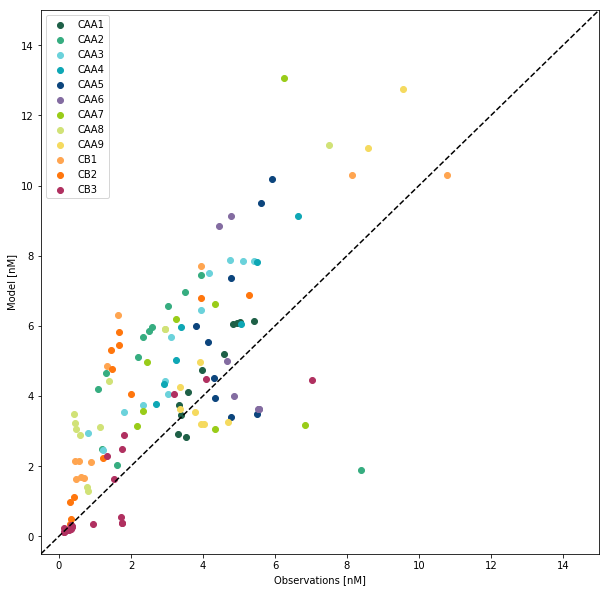

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

for station in range(0,len(station_j)):
    ax.scatter(mn_obser_all[station,:], mn_model_all[station,:], label=station_name[station], \
               color=station_colors[station])
    
#1:1 line
ax.plot([-0.5, 15], [-0.5, 15],'--k')
ax.set_xlim([-0.5,15])
ax.set_ylim([-0.5,15])

ax.set_xlabel('Observations [nM]')
ax.set_ylabel('Model [nM]')
ax.legend()

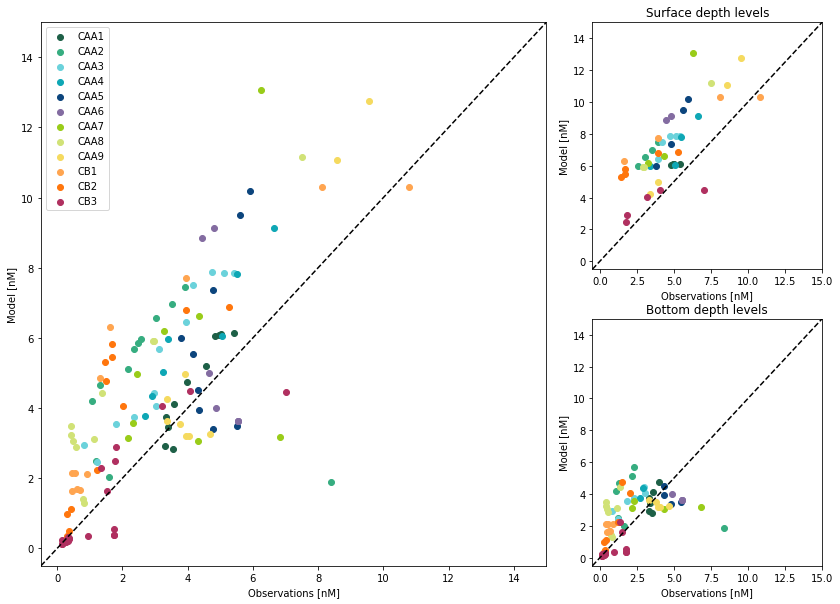

In [43]:
fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2) # main plot
ax2 = plt.subplot2grid((2, 3), (0, 2)) # surface plot
ax3 = plt.subplot2grid((2, 3), (1, 2)) # bottom plot

# Main plot
for station in range(0,len(station_j)):
    ax1.scatter(mn_obser_all[station,:], mn_model_all[station,:], label=station_name[station], \
               color=station_colors[station])
    
ax1.plot([-0.5, 15], [-0.5, 15],'--k')
ax1.set_xlim([-0.5,15])
ax1.set_ylim([-0.5,15])
ax1.set_xlabel('Observations [nM]')
ax1.set_ylabel('Model [nM]')
ax1.legend()

# Surface plot
for station in range(0,len(station_j)):
    depth_k  = search_depth(station_depths[:,station], depths_model)
    count=0
    for k in depth_k:
        if k < 20: #down to about 55 m
            ax2.scatter(mn_obser_all[station,count], mn_model_all[station,count], label=station_name[station], \
                       color=station_colors[station])
        count+=1

ax2.plot([-0.5, 15], [-0.5, 15],'--k')
ax2.set_xlim([-0.5,15])
ax2.set_ylim([-0.5,15])
ax2.set_xlabel('Observations [nM]')
ax2.set_ylabel('Model [nM]')
ax2.set_title('Surface depth levels')

# Bottom plot
for station in range(0,len(station_j)):
    depth_k  = search_depth(station_depths[:,station], depths_model)
    count=0
    for k in depth_k:
        if k > 20: #down from about 55 m
            ax3.scatter(mn_obser_all[station,count], mn_model_all[station,count], label=station_name[station], \
                       color=station_colors[station])
        count+=1
ax3.plot([-0.5, 15], [-0.5, 15],'--k')
ax3.set_xlim([-0.5,15])
ax3.set_ylim([-0.5,15])
ax3.set_xlabel('Observations [nM]')
ax3.set_ylabel('Model [nM]')
ax3.set_title('Bottom depth levels')

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Mn_scatter_plot_evaluation.png', bbox_inches='tight')

# Assess the Reliability Index

Reliability Index, RI (Leggett and Williams, 1981) --- “quantifies the average factor by which model predictions differ from observations” (Stow et al., 2009). It is in essence the root-mean-square deviation, but it uses the logarithm of the residual. This is useful when both large and small values need to be considered [Van Hulten et al., 2017].

\begin{equation}
RI = exp \sqrt{\frac{1}{N} \sum^N_{i=1}{\bigg(log \frac{O_i}{P_i}\bigg)^2}}
\end{equation}

where $O_i$ is the measured concentration with index i, $P_i$ is the model prediction associated to the respective observation i, and N is the number of observations.

In [44]:
def reliability_index(Obs, Pred):
    N = np.count_nonzero(~np.isnan(Obs))
    print('Number of points, N: ', N)
    ratio = [(np.log(Obs[i]/Pred[i]))**2 for i in range(0,N)]
    sum_ratio = np.nansum(ratio)
    sqrt_RI = np.sqrt(sum_ratio/N)
    RI = np.exp(sqrt_RI)
    print('Reliability index:   ', RI)
    return RI

In [45]:
RI = reliability_index(mn_obser_all.flatten(), mn_model_all.flatten())

Number of points, N:  137
Reliability index:    1.4581031129


Willmott skill score:

\begin{equation}
IA = 1 - \frac{\big\langle (P_i - O_i)^2 \big\rangle}{\big\langle (| P_i - \langle P_i \rangle | + | O_i - \langle O_i \rangle |)^2 \big\rangle}
\end{equation}

In [46]:
def willmott_score(Obs, Pred):
    N = np.count_nonzero(~np.isnan(Obs))
    
    numerator   = np.nanmean([(Pred[i]-Obs[i])**2 for i in range(0,N-1)])
    term1       = np.abs(Pred - np.nanmean(Pred))
    term2       = np.abs(Obs - np.nanmean(Obs))
    denominator = np.nanmean([(term1[i]+term2[i])**2 for i in range(0,N-1)])
    deviation   = numerator / denominator
    
    willmott    = 1 - deviation
    print('Willmott skill score: ', willmott)
        
    return willmott

In [47]:
IA = willmott_score(mn_obser_all.flatten(), mn_model_all.flatten())

Willmott skill score:  0.640468251828
